In [46]:
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [47]:
weekly_cancel = pd.read_csv("h2weekly.csv", parse_dates=True, index_col="Date")
#weekly_cancel["Date"] = pd.to_datetime(weekly_cancel["Date"])

In [48]:
weekly_cancel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115 entries, 2015-06-21 to 2017-08-27
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   IsCanceled  115 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


In [49]:
weekly_cancel

,IsCanceled
Date,
2015-06-21,97
2015-06-28,153
2015-07-05,228
2015-07-12,321
2015-07-19,159
...,...
2017-07-30,253
2017-08-06,269
2017-08-13,341


<AxesSubplot:xlabel='Date'>

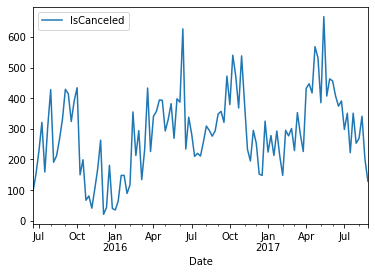

In [50]:
weekly_cancel.plot()

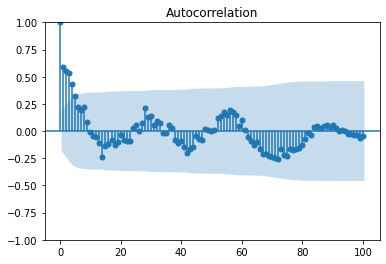

In [51]:
plot_acf(weekly_cancel,lags=100);

/Users/wojciechstasiuk/Documents/git_projects/hotel_cancelation/h_c/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


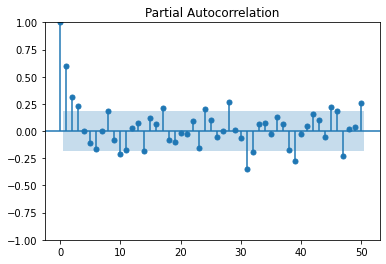

In [52]:
plot_pacf(weekly_cancel,lags=50);

In [53]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg
from pydlm import modelTuner


In [54]:
test_size = int(len(weekly_cancel) * 0.9)
train = weekly_cancel[:test_size]
test = weekly_cancel[-test_size:]

In [220]:
# A linear trend
linear_trend = trend(degree=1, discount=1, name='linear_trend', w=1)
# A seasonality
seasonal28 = seasonality(period=29, discount=1, name='seasonal28', w=1)
# Build a simple dlm
simple_dlm = dlm(train["IsCanceled"]) + linear_trend + seasonal28

In [221]:
simple_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/wojciechstasiuk/Documents/git_projects/hotel_cancelation/h_c/lib/python3.9/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


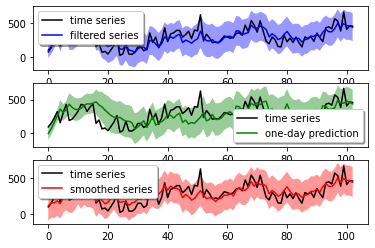

In [222]:
simple_dlm.plot()

In [223]:
predictions_simple , _ = simple_dlm.predictN(test_size)

In [224]:
predictions_simple = pd.Series(data=predictions_simple,index=test.index,name=" simple model predictions")

<AxesSubplot:xlabel='Date'>

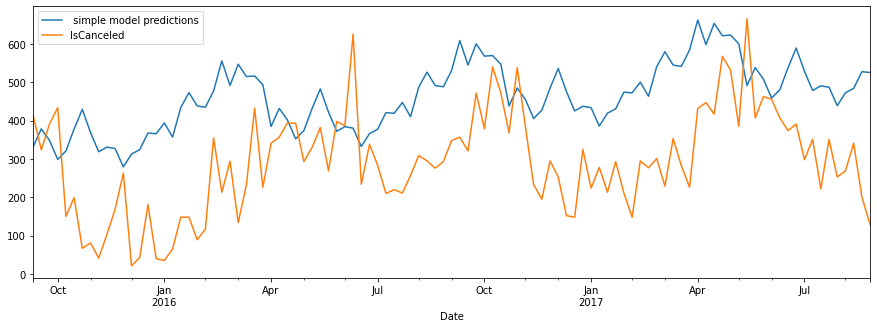

In [225]:
predictions_simple.plot(figsize=(15,5),legend=True)
test["IsCanceled"].plot(legend=True)

In [226]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(predictions_simple,test["IsCanceled"])

In [227]:
np.sqrt(error)

211.1975456647449

# DLM with dynamic and autoregressive components

In [228]:
simple_dlm.ls()

The static components are
linear_trend (degree = 2)
seasonal28 (degree = 29)
 
There is no dynamic component.
 
There is no automatic component.


In [233]:
dynamic_feature = [[1.0, 2.0] for i in range(len(train))]
regressor = dynamic(features=[[1]] ,discount=0.9, name='dynamic', w=1)
autoreg = autoReg(degree=2, discount=1, name='automatic', w=1)
dlm_model = dlm(train["IsCanceled"]) + linear_trend + seasonal28  + autoreg #+ regressor
dlm_model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [234]:
predictions_list , _ = dlm_model.predictN(test_size)
predictions_series = pd.Series(data=predictions_list,index=test.index,name="complex model predictions")

In [235]:
error = mean_squared_error(predictions_series,test["IsCanceled"])
np.sqrt(error)

206.52567828003248

<AxesSubplot:xlabel='Date'>

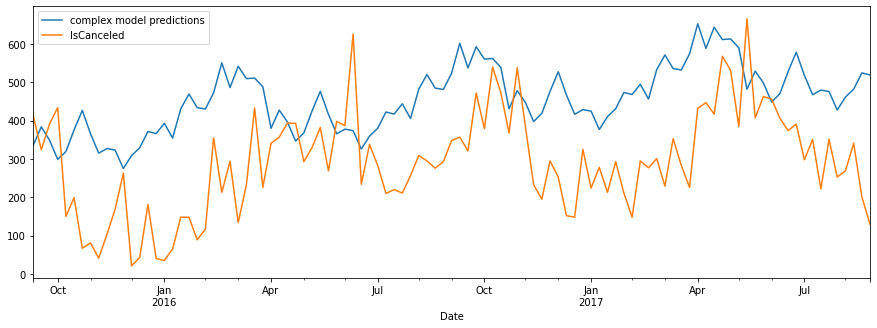

In [236]:
predictions_series.plot(figsize=(15,5),legend=True)
test["IsCanceled"].plot(legend=True)